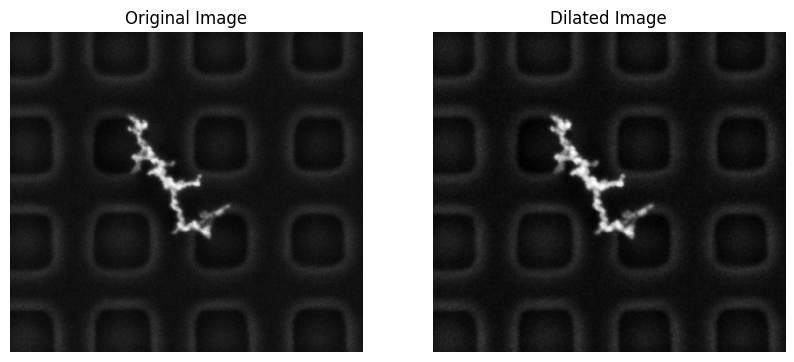

In [18]:
import cv2 as cv2
import math
import matplotlib.pyplot as plt

# 开运算
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# 膨胀
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

image_path = '/home/pxl/myProject/血管分割/1f912e383c074170ae29d7859f3e845b.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

image_dilated = cv2.dilate(image, kernel1, iterations=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(image_dilated, cmap='gray')
axs[1].set_title('Dilated Image')
axs[1].axis('off')
plt.show()

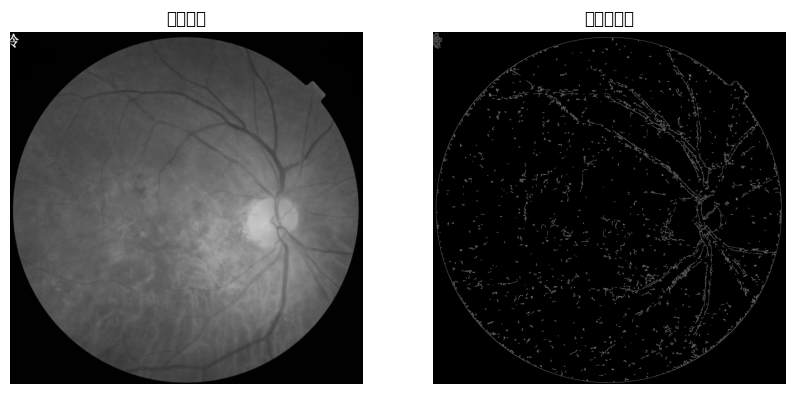

In [46]:
import cv2 as cv
import matplotlib.pyplot as plt

image_path = '/home/pxl/myProject/血管分割/FIVE原始彩色图像.png'
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

edge = cv.Canny(image,15,40)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('原始图像')
axs[0].axis('off')
axs[1].imshow(edge, cmap='gray')
axs[1].set_title('处理后图像')
axs[1].axis('off')
plt.show()



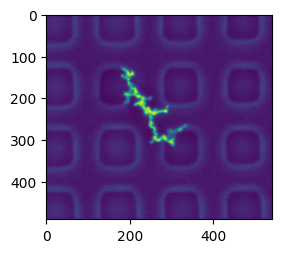

TypeError: Invalid shape (1, 4, 1, 2) for image data

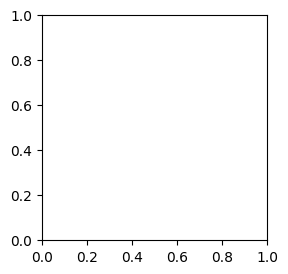

In [15]:

import cv2 as cv
import math
import matplotlib.pyplot as plt

image_path = '/home/pxl/myProject/血管分割/1f912e383c074170ae29d7859f3e845b.png'
image_thre = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.imshow(image_thre)
plt.show()


# 获取椭圆结构元素的卷积核，尺寸为5x5和3x3
kernel1 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))  # 定义大小为5x5的椭圆结构元素
kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))  # 定义大小为3x3的椭圆结构元素

# 使用开运算消除二值化图像中的小亮点
image_open = cv.morphologyEx(image_thre, cv.MORPH_OPEN, kernel2, iterations=1)  # 对图像进行开运算，消除小亮点
# 使用膨胀操作处理图像
image_dil = cv.dilate(image_open, kernel1)  # 对开运算后的图像进行膨胀操作

# 检测图像中的轮廓
contours, hierarchy = cv.findContours(image_dil, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)  # 检测图像中的轮廓

# 如果检测到轮廓
if len(contours) != 0:
    # 初始化每个轮廓的索引为一个单独的聚类
    cnt_idxs = [[idx] for idx in range(len(contours))]  # 初始化轮廓索引列表，每个轮廓作为单独的聚类
    pre_len = len(cnt_idxs)  # 记录当前聚类数

    # 重复聚类过程直到所有轮廓都被聚类
    while len(cnt_idxs) > 1:
        tmp_cnt_idxs = []  # 临时存储新的聚类结果
        flags = [False] * len(cnt_idxs)  # 标记哪些聚类已经被处理
        for first in range(len(cnt_idxs)):
            for second in range(len(cnt_idxs)):
                if first == second or flags[first] or flags[second]:  # 跳过相同的聚类和已经处理过的聚类
                    continue
                is_find = False  # 标记是否找到匹配的聚类
                for fidx in cnt_idxs[first]:
                    cnt = contours[fidx]  # 获取第一个轮廓
                    _, radius1 = cv.minEnclosingCircle(cnt)  # 获取第一个轮廓的最小外接圆半径
                    M = cv.moments(cnt)  # 获取第一个轮廓的空间矩
                    cx = int(M["m10"] / M["m00"])  # 计算第一个轮廓的重心X坐标
                    cy = int(M["m01"] / M["m00"])  # 计算第一个轮廓的重心Y坐标
                    for sidx in cnt_idxs[second]:
                        new_cnt = contours[sidx]  # 获取第二个轮廓
                        M2 = cv.moments(new_cnt)  # 获取第二个轮廓的空间矩
                        cx2 = int(M2["m10"] / M2["m00"])  # 计算第二个轮廓的重心X坐标
                        cy2 = int(M2["m01"] / M2["m00"])  # 计算第二个轮廓的重心Y坐标
                        _, radius2 = cv.minEnclosingCircle(new_cnt)  # 获取第二个轮廓的最小外接圆半径
                        sq1 = (cx2 - cx) * (cx2 - cx)  # 计算两个轮廓重心X坐标差的平方
                        sq2 = (cy2 - cy) * (cy2 - cy)  # 计算两个轮廓重心Y坐标差的平方
                        dist = math.sqrt(sq1 + sq2)  # 计算两个轮廓重心之间的距离
                        if dist - radius2 - radius1 < 30:  # 如果距离小于阈值
                            is_find = True  # 标记找到匹配的聚类
                            tmp_cnt_idxs.append(cnt_idxs[first] + cnt_idxs[second])  # 合并两个聚类
                            flags[first] = flags[second] = True  # 标记这两个聚类已经处理过
                            break  # 跳出内层循环
                    if is_find:
                        break  # 跳出外层循环
        for idx, flag in enumerate(flags):
            if not flag:  # 如果聚类没有被处理
                tmp_cnt_idxs.append(cnt_idxs[idx])  # 将其加入新的聚类结果中
        cnt_idxs = tmp_cnt_idxs  # 更新聚类结果
        if pre_len == len(cnt_idxs):  # 如果聚类数没有变化
            break  # 结束循环
        else:
            pre_len = len(cnt_idxs)  # 更新当前聚类数

plt.subplot(1,2,2)
plt.imshow(contours)
plt.show()